<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Monday 08 July 2019</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/amazon_fires/tree/EGU2020">github.com/douglask3/amazon_fires/tree/EGU2020</td>
</tr>
</table>
<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1,* </sup> Douglas Ian Kelley,
<sup>2 </sup>Chantelle Burton, 
<sup>3 </sup>Rhys Whitley,
<sup>1 </sup>Chris Huntingford,
<sup>4 </sup>Ioannis Bistinas, 
<sup>1,5 </sup>Megan Brown, 
<sup>6 </sup>Ning Dong, 
<sup>1 </sup>Toby R. Marthews
<br>
<br>
<br>
<sup>*  </sup> douglas.i.kelley@gmail.com
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>ATOS Nederland B.V., Amstelveen, The Netherlands
<br>
<sup>5 </sup>School of Physical Sciences, The Open University, Milton Keynes, UK
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
The previous notebook quantified the probability distribution of the model parameters of our global fire model. Here, we sample this distribution to obtain a number of key measures of fire regime: burnt area, and the limitation and sensitivity of fuel, moisture, ignitions and suppression controls.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

# Load libraries

In [273]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm


def npLogit(x):
    return np.log(x/(1.0-x))

# We're using the row which has minimum sigma
def newCubes3D(variable, step, eg_cube_in, dimname = 'model_level_number'):
    
    
    #maxV = np.max(eg_cube_in.data)    
    #maxV = np.min([1.0, np.ceil(maxV) * 1.5])
    
    def newCube(i):
        coord = iris.coords.AuxCoord(i, dimname)
        eg_cube = eg_cube_in.copy()
        eg_cube.data[eg_cube.data > 0.0] = 0.0
        try:
            eg_cube.remove_coord(dimname)
        except:
            pass
        eg_cube.add_aux_coord(coord)
        return(eg_cube)
    
    if not hasattr(step, '__len__'):
        minV = np.round(npLogit(np.min(eg_cube_in.data[eg_cube_in.data>0.0]))) #* 2.0
        maxV = -minV#np.round(npLogit(np.max(eg_cube_in.data[eg_cube_in.data<1.0])))
    
        minV = minV - 1
        step = np.arange(minV ,maxV, step)     
    
    eg_cubes = iris.cube.CubeList([newCube(i) for i in step])
    eg_cubes = eg_cubes.merge()[0]
    
    return(eg_cubes)


## Input information

Modify 'title_output' and you'll also need to mannually mkdir of the title_output in respective 'figures' folder. You can change which input are used to put into the model by changing the file dictionaries.
JULES data only runs from July 2000 to Dec 2010, so I created a separate dictionary for that (below). If you use this, you'll also have to change the output and figure directory.


Data in 'retrieved_codes/2000-2014' and 'jul2000-2014' has already been scaled and adjusted (e.g. lightning, RH).
The jul2000-2014 files have 168 time points and start at July 2000 and go up to June 2014, like the obs files. This makes them compatible when mixing up obs + UKESM runs.

In [274]:
dir = '../inputs/amazon_region/'

files = {'soilwMax'           : 'vegetation/MaxOverMean_soilw.0-10cm.gauss.2001-2019.nc',
         'shallow_soilw'      : 'climate/shallow_soilw.0-10cm.gauss.2001-2019.nc',
         'deep_soilw'         : 'climate/deep_soilw.10-200cm.gauss.2001-2019.nc',
         'precip'             : 'climate/precip2001-2019.nc',
         'emc'                : 'climate/emc-2001-2019.nc',
         'treeCover'          : 'vegetation/treecover-2001-June2018.nc',
         'lightning'          : 'climate/lightning2001-2019.nc',
         'pasture'            : 'human/pasture2001-2019.nc',
         'population_density' : 'human/population_density-PD_HYDEv3.2_2001-2018.nc',
         'cropland'           : 'human/cropland2001-2019.nc',
         'vegcover'           : 'vegetation/vegcover-2001-June2018.nc',
         'burnt_area'         : 'fire_counts/burnt_area_MCD64A1.006.nc'}


In [275]:
param_file = '../outputs/params-for_sampling_logitnorm_PAdd_PT_Crop.csv'#params-test_errors-2002-attempt2-NewMoist-DeepSoil2Tnorm-burnt_area_MCD.csv'

title_output = 'constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX'
fire_Season = [8]

Open data. The model takes data in the same dict class as above.

In [276]:
##open data
input_data = {}
for key, file in files.items():
    data = iris.load_cube(dir + file)
    input_data[key] = data

params = pd.read_csv(param_file)

We will recycle pervious years data for variables for which we do not have data for in 2019

In [277]:
ntime = max([dat.shape[0] for __, dat in input_data.items()])

ntime = 0 
for key, dat in input_data.items(): 
    if dat.shape[0] > ntime:
        ntime = dat.shape[0]
        temp = dat.copy()

for key, dat in input_data.items():
    print(key)
    ntime_d = dat.shape[0]
    if ntime_d < ntime:
        temp.data[0:ntime_d] = dat.data
        for mn in range(ntime_d, ntime):
            print(mn)
            ntime_d_lastYr = mn - 12
            print(ntime_d_lastYr)
            temp.data[mn] = temp.data[ntime_d_lastYr].copy()
            
        input_data[key] = temp.copy()

soilwMax
227
215
228
216
shallow_soilw
228
216
deep_soilw
228
216
precip
emc
226
214
227
215
228
216
treeCover
210
198
211
199
212
200
213
201
214
202
215
203
216
204
217
205
218
206
219
207
220
208
221
209
222
210
223
211
224
212
225
213
226
214
227
215
228
216
lightning
pasture
224
212
225
213
226
214
227
215
228
216
population_density
210
198
211
199
212
200
213
201
214
202
215
203
216
204
217
205
218
206
219
207
220
208
221
209
222
210
223
211
224
212
225
213
226
214
227
215
228
216
cropland
224
212
225
213
226
214
227
215
228
216
vegcover
210
198
211
199
212
200
213
201
214
202
215
203
216
204
217
205
218
206
219
207
220
208
221
209
222
210
223
211
224
212
225
213
226
214
227
215
228
216
burnt_area
228
216


Plotting annual averages just to make sure the data looks senible

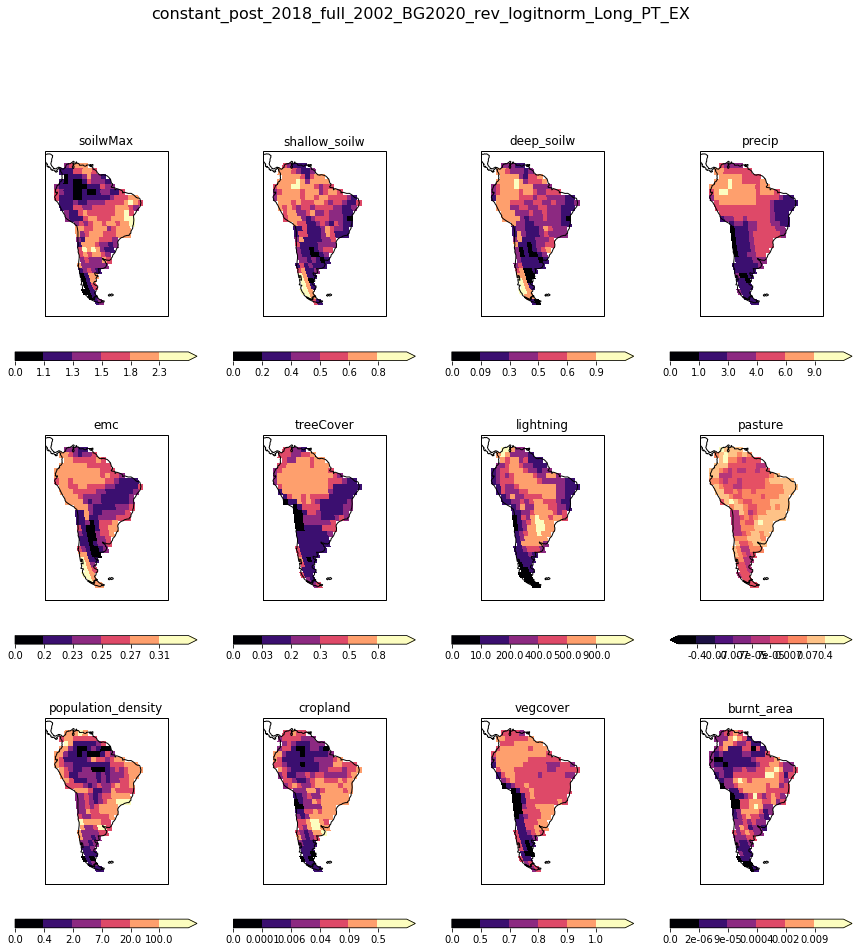

In [278]:
nd = 0

plt.figure(figsize = (15, 20))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 4, 4, nd, cmap = 'magma', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)


## The model
The model is defined Kelley et al. 2019 and Kelley et al. submitted (available soon). See those for full model equations. Below, we define the model, this time as a class object on gridded temporal data and using ```np``` rather than ```tt```. This could be moved into a library at some point, but I've defined it here so you can have a proper look.

The model calculates a number of things needed to predict burnt area, and a few metric (potential limitation and sensitivity) on the fly. The things needed to calculate burnt area are ``ConFIRE.``:

* **Controls**:
    * ``fuel``: fuel continuity
    * ``moisture``: fuel mositure content
    * ``ignitions``: potential ignitions
    * ``suppression``: human fire suppression and landscape fragmentation

* **Limitation from controls**, the maximum allowed fire considering limitation from:
    * ``standard_fuel``:  fuel
    * ``standard_moisture``:  moisture
    * ``standard_ignitions``:  ignitions
    * ``standard_suppression``:  suppression

* and ``burnt_area``: burnt area from all limitations

Things calculated on the fly are:

* **Potential limitation**, the increase in burnt area if limitation where removed from:
    * ``potential_fuel``:  fuel
    * ``potential_moisture``:  moisture
    * ``potential_ignitions``:  ignitions
    * ``potential_suppression``:  suppression

* **Sensitvity**, the rate of change in burnt area for a given control, relative to the maximum possible rate of change for that controls:
    * ``sensitivity_fuel``:  fuel
    * ``sensitivity_moisture``:  moisture
    * ``sensitivity_ignitions``:  ignitions
    * ``sensitivity_suppression``:  suppression

In [7]:
class ConFIRE(object):
    def __init__(self, data, params):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params


        ## finds controls
        self.fuel = self.control_fuel(data['vegcover'], data['soilwMax'], self.params['fuel_pw'],
                                      self.params['fuel_pg'])
        
        self.emcw = self.emc_weighted(data['emc'], data["precip"], self.params['wd_pg'])
        
        self.moisture = self.control_moisture(data['shallow_soilw'], data['deep_soilw'],
                                              self.emcw, data['treeCover'],
                                              self.params['cMs'], self.params['cM'], self.params['cMT'], 
                                              self.params['kM'], self.params['pT'])

        self.ignitions = self.control_ignitions(data['lightning'], data['pasture'], data['cropland'],
                                                data['population_density'],
                                                self.params['cP'], self.params['cPS'], 
                                                self.params['cC'], self.params['cCS'], 
                                                self.params['cD1'])

        self.suppression = self.control_suppression(data['cropland'], data['population_density'],
                                              self.params['cD2'])

        ## calculates limiting factor of each control.
        self.standard_fuel        = self.sigmoid(self.fuel       ,
                                            self.params[       'fuel_x0'], self.params[       'fuel_k'])  
        
        self.standard_moisture    = self.sigmoid(self.moisture   ,
                                            self.params[   'moisture_x0'], -self.params[   'moisture_k'])
        self.standard_ignitions   = self.sigmoid(self.ignitions   ,
                                            self.params[  'ignition_x0'], self.params[  'ignition_k'])
        self.standard_suppression = self.sigmoid(self.suppression,
                                            self.params['suppression_x0'], -self.params['suppression_k'])
        
        
        self.error = self.params['sigma']
        ## burnt area us just limitation of each control muliplied together.
        self.burnt_area_mode = self.standard_fuel * self.standard_moisture * self.standard_ignitions * \
            self.standard_suppression * self.params['max_f']
        
        ## find the mean burnt area
        self.burnt_area_calPDF(data, self.params['p0'], self.params['pp'])
        
        #self.burnt_area_median = self.burnt_area_mode * 2.0 * self.error
        #self.burnt_area_mean = self.burnt_area_median * 1.5 
        
        
        
        self.burnt_area = self.burnt_area_mean.copy() #* (1.0-self.p0)
        
        self.standard_moisture    = self.standard_moisture    / self.sigmoid(0.0, self.params['moisture_x0'],
                                                 -self.params['moisture_k'])
        self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
                                                 -self.params['suppression_k'])
        
        
        
        try: 
            self.alpha_skew = self.params['alpha_skew']
        except:
            pass

        ## if the inputs are iris cubes, we can add some useful metadata
        try:
            self.burnt_area.long_name = "burnt_area"
            self.burnt_area_mode.long_name = "burnt_area_mode"
            #self.burnt_area_median.long_name = "burnt_area_median"
            self.burnt_area_mean.long_name = "burnt_area_mean"

            self.fuel.long_name = "fuel continuity"
            self.fuel.units = '1'

            self.moisture.long_name = "moisture content"
            self.moisture.units = '1'

            self.ignitions.long_name = "ignitions"
            self.ignitions.units = 'km-2'

            self.suppression.long_name = "suppression"
            self.suppression.units = '1'

            self.standard_fuel.long_name = "standard_fuel"
            self.standard_moisture.long_name = "standard_moisture"
            self.standard_ignitions.long_name = "standard_ignitions"
            self.standard_suppression.long_name = "standard_suppression"

            self.standard_fuel.units = '1'
            self.standard_moisture.units = '1'
            self.standard_ignitions.units = '1'
            self.standard_suppression.units = '1'
        except:
            pass        
    
        
    def control_fuel(self, vegcover, alphaMax, fuel_pw, fuel_pg):
        """
        Definition to describe fuel load: while return the input; capability to be modified later.
        """
        return (vegcover**(fuel_pw+1)) * (fuel_pg * (alphaMax-1) + 1) / (1 + fuel_pg)
    
    def emc_weighted(self, emc, precip, wd_pg):
        try:
            wet_days = 1 - np.exp(-wd_pg * precip)
            emcw = wet_days + (1-wet_days) * emc
        except:
            emcw = emc.copy()
            emcw.data  = 1 - np.exp(-wd_pg * precip.data)
            emcw.data = emcw.data + (1-emcw.data) * emc.data
        return(emcw)

    def control_moisture(self, shallow_soil, deeps_soil, emc, treeCover, cMs, cM, cMT, kM, pT):
        """
        Definition to describe moisture
        """
        moist = (shallow_soil + cMs * deeps_soil + cM*emc + cMT * (treeCover**pT)) / (1 + cMs + cM + cMT)
        moist.data = 1 - np.log(1 - moist.data*kM)
        return moist


    def control_ignitions(self, lightning, pasture, cropland, population_density, cP, cPS, cC, cCS, cD1):
        """
        Definition for the measure of ignition
        """
        pasSin = pasture.copy()
        pasSin.data = np.sin(math.pi*pasSin.data)
        
        cropSin = cropland.copy()
        cropSin.data = np.sin(math.pi*cropSin.data)
        ignite = lightning + cP*pasture + cPS*pasSin + cC * cropland +cCS * cropSin + cD1*population_density
        
        return ignite


    def control_suppression(self, cropland, population_density, cD2):
        """
        Definition for the measure of fire supression
        """
        return cropland + cD2*population_density

        """
        Defines potential limitation for each control in turn
        """
    def potential_fuel(self):
        return self.potential(self.standard_fuel, "potential_fuel")


    def potential_moisture(self):
        return self.potential(self.standard_moisture, "potential_moisture")


    def potential_ignitions(self):
        return self.potential(self.standard_ignitions, "potential_ignitions")


    def potential_suppression(self):
        return self.potential(self.standard_suppression, "potential_suppression")


    def sensitivity_fuel(self):
        return self.sensitivity(self.fuel, self.params['fuel_x0'], self.params['fuel_k'],
                                self.standard_fuel, "sensitivity_fuel")

    """
    Defines sensitivity for each control in turn
    """
    def sensitivity_moisture(self):
        return self.sensitivity(self.moisture, self.params['moisture_x0'], -self.params['moisture_k'],
                                self.standard_moisture, "sensitivity_moisture")


    def sensitivity_ignitions(self):
        return self.sensitivity(self.ignitions, self.params['ignition_x0'], self.params['ignition_k'],
                                self.standard_ignitions, "sensitivity_ignitions")


    def sensitivity_suppression(self):
        return self.sensitivity(self.suppression, self.params['suppression_x0'], -self.params['suppression_k'] ,
                                self.standard_suppression, "sensitivity_suppression")


    def sensitivity(self, x, x0, k, fi, long_name = None):

        gradient = self.gradient(x, x0, k)
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: pass
        return sens


    def control_removal(self, fi):
        return self.burnt_area_mode/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.burnt_area_mode.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x
    
    def burnt_area_calPDF(self, data, p0, pp):
        
        mask = np.logical_not(self.burnt_area_mode.data.mask)
        self.burnt_area_pdf = newCubes3D('burnt_area', 0.2, data['burnt_area'])
        
        self.burnt_area_mean = self.burnt_area_mode.copy()
        self.burnt_area_mean.data[mask] = 0.0
        
        level_no = self.burnt_area_pdf.coord('model_level_number').points
        
        dist = norm(npLogit(self.burnt_area_mode.data[mask]), self.error)
        
        self.pz = 1.0 - (self.burnt_area_mode.data[mask]**pp) * (1.0 - p0)
        
        self.burnt_area_pdf.data[0][mask] = self.pz 
        x = self.burnt_area_pdf.coord('model_level_number').points
        for k in range(1, self.burnt_area_pdf.shape[0]):       
            self.burnt_area_pdf.data[k][mask] = dist.pdf(x[k]) * (1.0 - self.pz)
            self.burnt_area_mean.data[mask]  = self.burnt_area_mean.data[mask] +  dist.pdf(x[k]) * (1.0 - self.pz)  *(1/(1+np.exp(-x[k])))
                                     
        PDFtot = self.burnt_area_pdf.collapsed(['model_level_number'], iris.analysis.SUM)
        
        self.burnt_area_mean.data = self.burnt_area_mean.data/ PDFtot.data
       
        
        

In [8]:
model = ConFIRE(input_data, params.loc[params["sigma"].idxmin()])

#### Check that everything is working okay
Here, we run the model with the minium error spread and plot each of the outputs mentioned above to make sure everything is happy

#### Fire measure

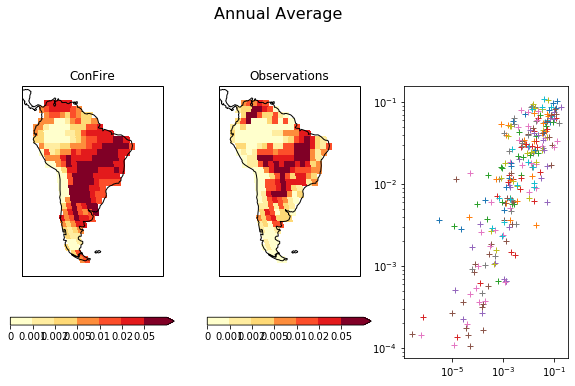

In [9]:
def plot_model_burnt_area(model, level, mnths = None, nmth_ys = 12,
                          figsize = (10, 11), Title = "Annual Average ", N = 2, M = 3, n = 0, 
                          addScatter = False, *args, **kw):
    if figsize is not None: plt.figure(figsize = figsize)
    if mnths is None: mnths = np.arange(0, 12*15)
    
    sim = model.burnt_area[mnths].collapsed('time', iris.analysis.MEAN)
    
    sim.long_name = "ConFire"
    sim.data = sim.data * nmth_ys

    plot_lonely_cube(sim, N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", *args, **kw)

    obs = input_data["burnt_area"][mnths].collapsed('time', iris.analysis.MEAN)*nmth_ys
    obs.long_name = "Observations"
    plot_lonely_cube(obs, N, M, n + 2, levels = level, cmap = "brewer_YlOrRd_09", *args, **kw)
    
    if addScatter:
        plt.subplot(N, M, n + 3)
        plt.plot(obs.data, sim.data, '+')
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
    plt.subplots_adjust(top=0.88)
    plt.suptitle(Title, fontsize=16)
    plt.subplots_adjust(top=0.88)

            
clevels = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]


def plot_fire_month(*args, **kw):     
    plot_model_burnt_area(model, clevels, extend = 'max', *args, **kw)
            
plot_fire_month(addScatter = True)

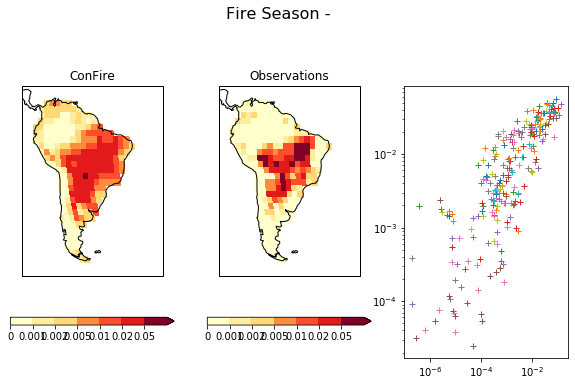

In [10]:
fire_Season = np.array([6,7,8])
fire_Seasons = np.array([fire_Season + yr*12 for yr in range(0, 19)])
fire_Season = fire_Seasons[0:15].flatten()
    
plot_fire_month(fire_Season, 3, Title = "Fire Season - ", addScatter = True)

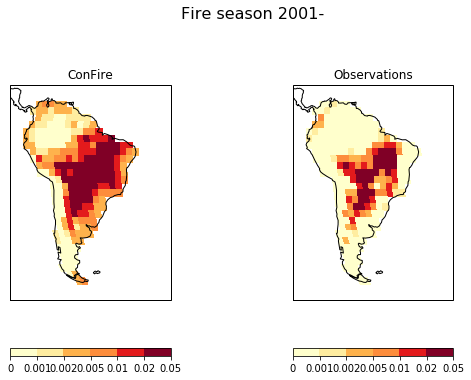

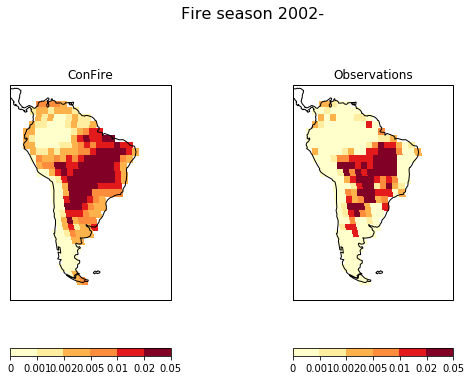

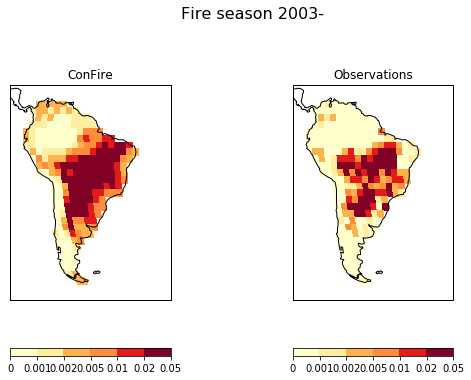

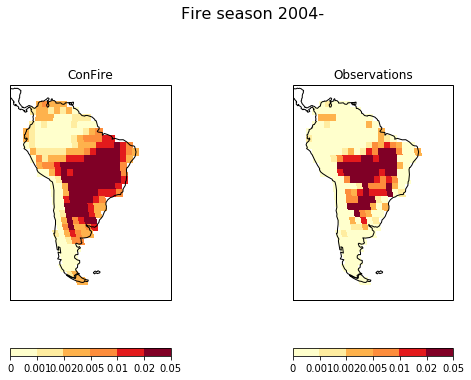

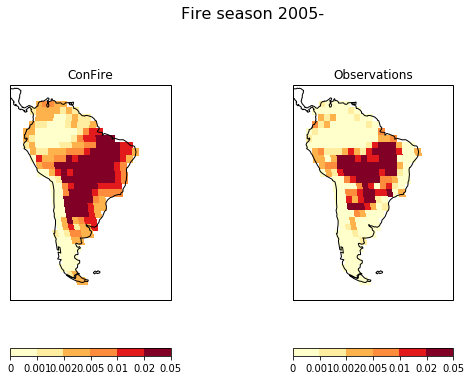

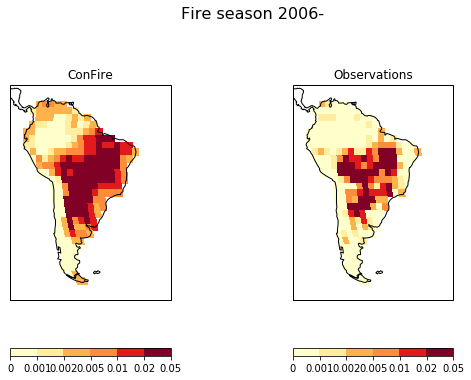

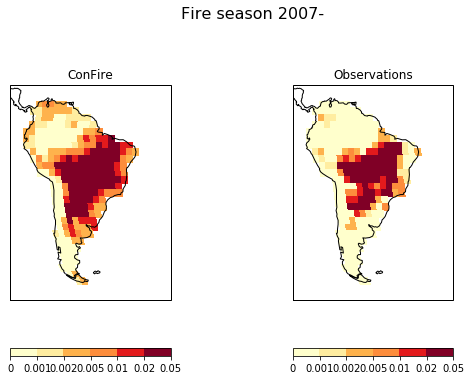

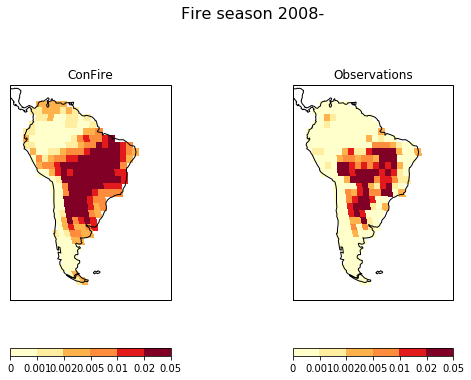

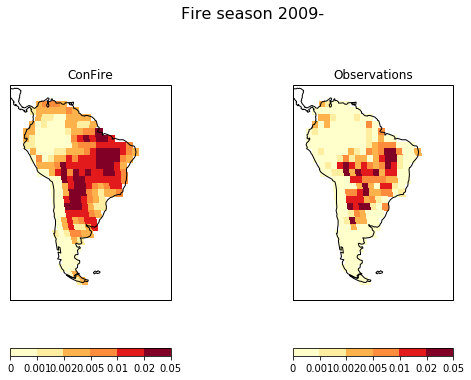

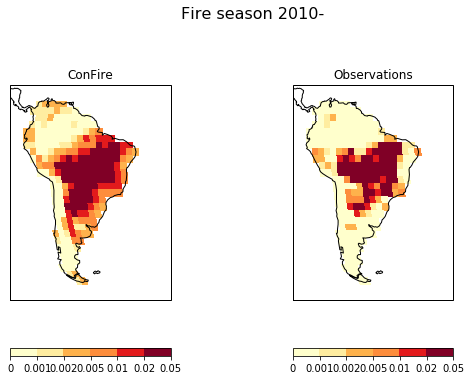

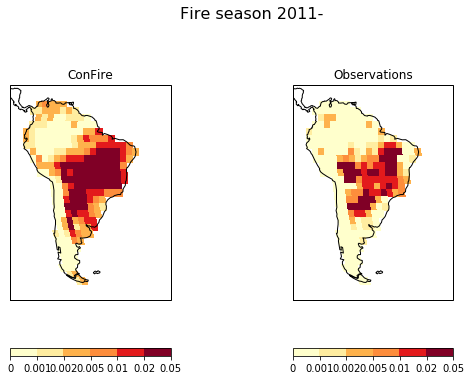

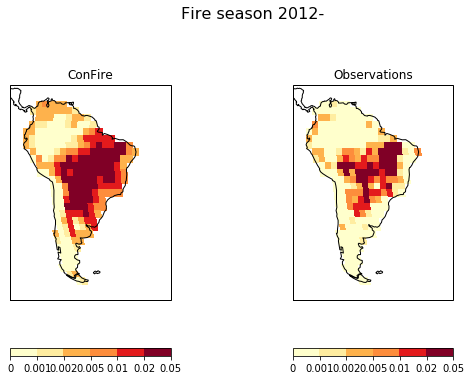

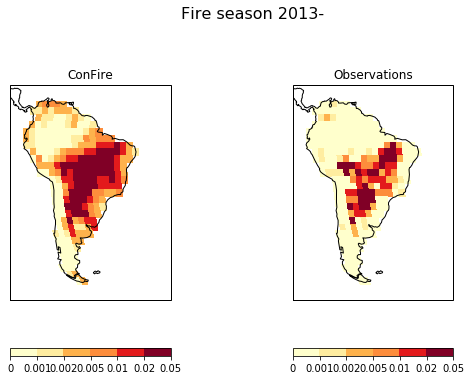

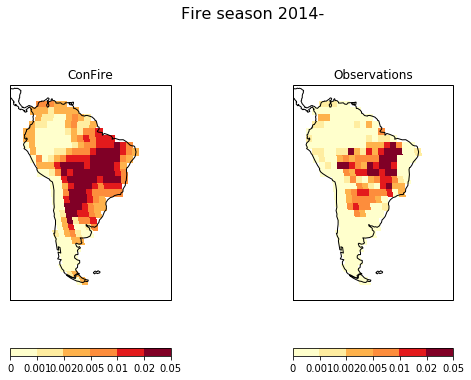

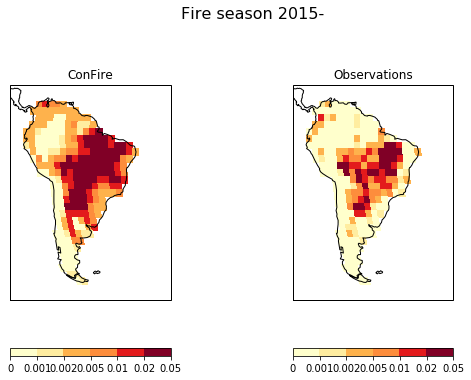

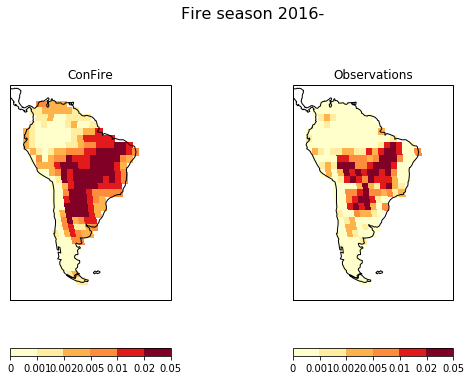

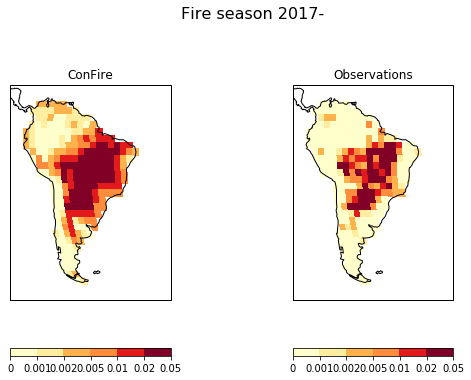

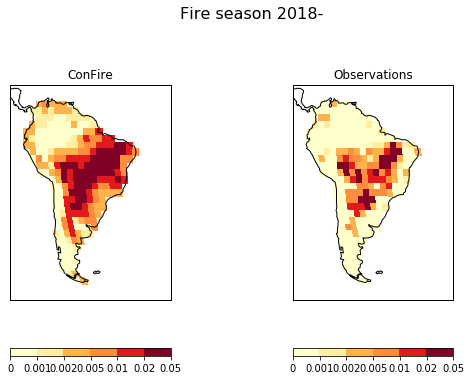

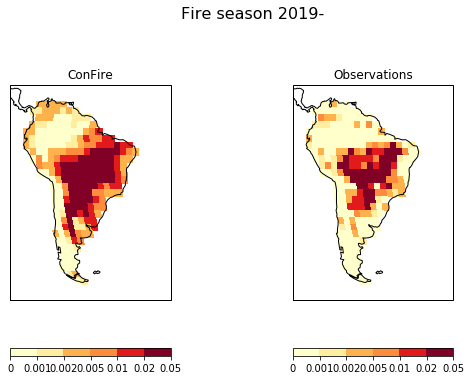

In [11]:
for yr, season in zip(range(0, 19), fire_Seasons):
    plt.figure(figsize = (8, 10))
    plot_model_burnt_area(model, clevels, mnths = season, nmth_ys = 3,
                          Title = "Fire season " + str(yr + 2001) + '-',
                          figsize = None, M = 2, n = 0)
    plt.show()

#### Controls

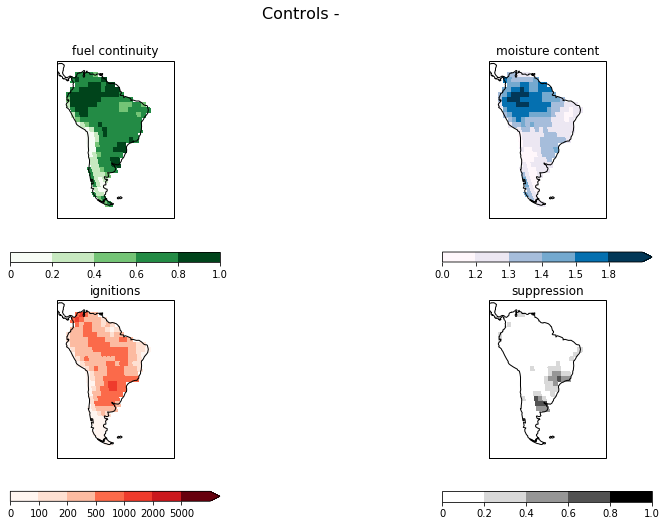

In [12]:
cmap_fuel = 'brewer_Greens_09'
cmap_moisture = 'brewer_PuBu_09'
cmap_ignitions = 'brewer_Reds_09'
cmap_suppression = 'brewer_Greys_09'

levels_frac = [0,0.2, 0.4, 0.6,  0.8,  1.0]
#levels_frac = [0,0.45,  0.5, 0.55, 1.0]
levels_ignitions = [0, 100, 200,500, 1000, 2000, 5000]
levels_moisture = [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    
def plotModComponet(comp, n, mnths = None, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    N = 2, M = 2, *args, **kws):
    if mnths is None: mnths = np.arange(0, 12*15)
    
    comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if scale is not None: comp.data = comp.data * scale
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, N, M, n, levels = levels, cmap = cmap, *args, **kws)

def plot_fire_month(Title = '',  **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.fuel, 1, cmap = cmap_fuel, levels = levels_frac, **kw)
    plotModComponet(model.moisture, 2, cmap = cmap_moisture, levels = None, extend = 'max', **kw)
    plotModComponet(model.ignitions, 3, cmap = cmap_ignitions, levels = levels_ignitions, extend = 'max', **kw)
    plotModComponet(model.suppression, 4, cmap = cmap_suppression, levels = levels_frac, **kw)
    plt.suptitle('Controls - ' + Title, fontsize=16)
    plt.subplots_adjust(top=0.88)
    
            
plot_fire_month()

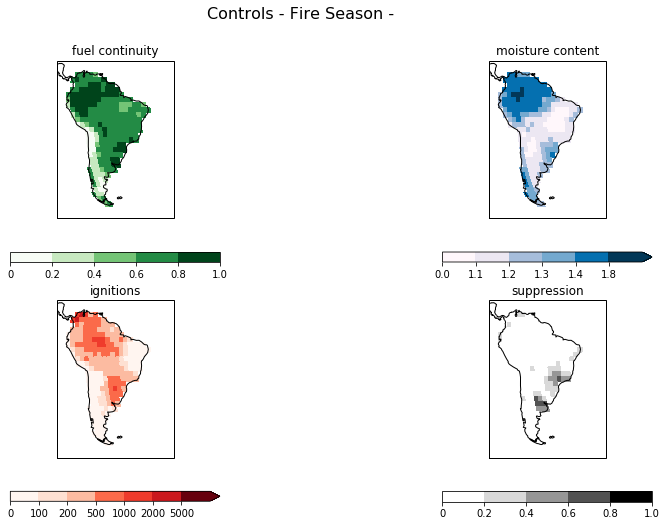

In [13]:
plot_fire_month('Fire Season - ', mnths = fire_Season)

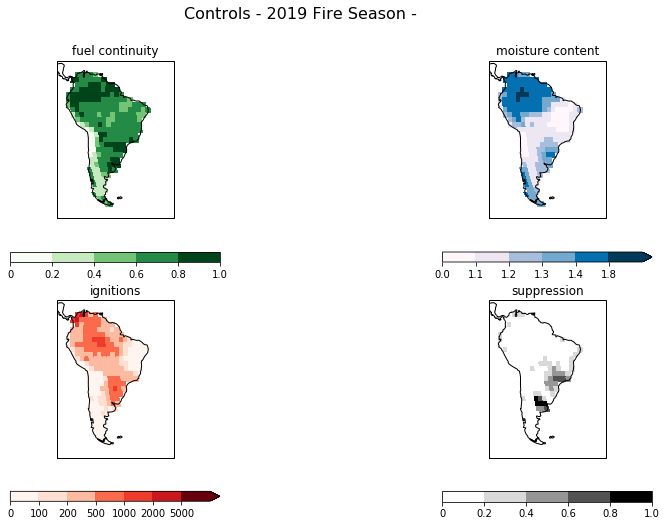

In [14]:
plot_fire_month('2019 Fire Season - ', mnths = np.array([6, 7, 8]) + 12 * 17)

#### Standard Limitation

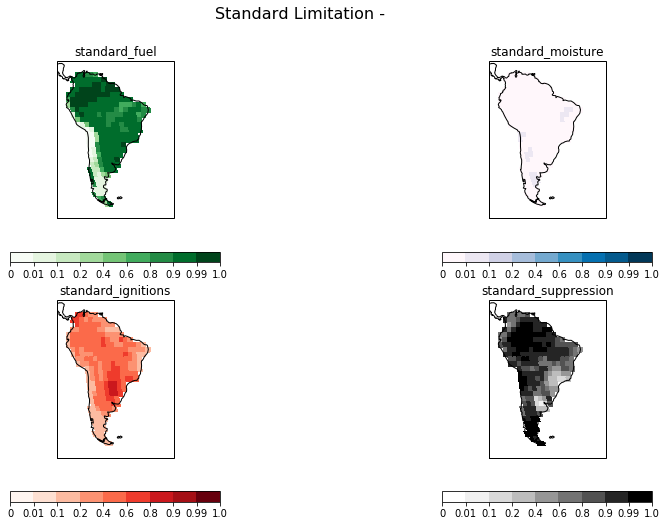

In [15]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
#levels = [0, 1.0, 1.1, 1.5, 2.0]
def plot_fire_month(**kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.standard_fuel, 1, cmap = cmap_fuel, levels = levels, **kw)
    plotModComponet(model.standard_moisture, 2, cmap = cmap_moisture, levels = levels, **kw)
    plotModComponet(model.standard_ignitions, 3, cmap = cmap_ignitions, levels = levels, **kw)
    plotModComponet(model.standard_suppression, 4, cmap = cmap_suppression, levels = levels, **kw)
    plt.suptitle('Standard Limitation - ', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month()

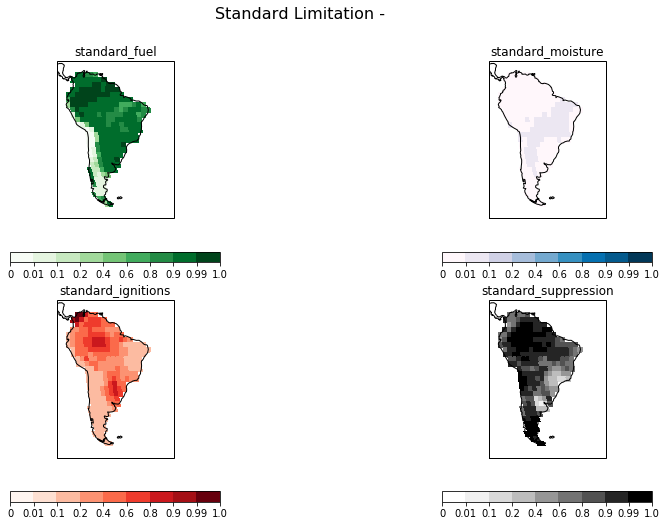

In [16]:
plot_fire_month(mnths = fire_Season)

#### Potential limitation

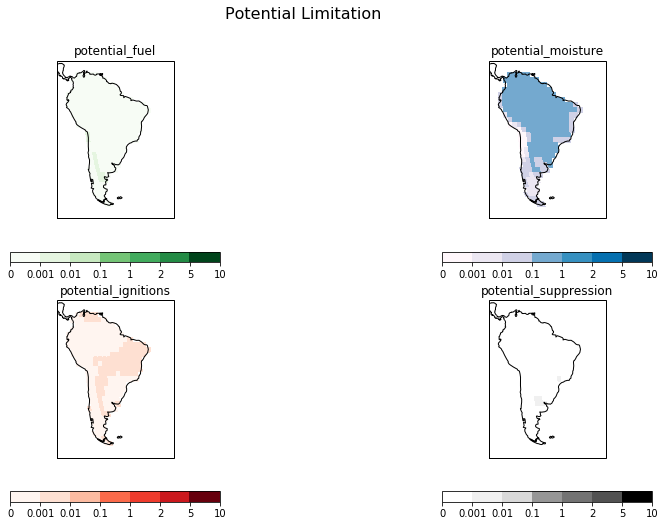

In [17]:
levels = [0, 0.001, 0.01, 0.1, 1, 2, 5, 10]
def plot_fire_month(**kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.potential_fuel(), 1, levels = levels,
                    cmap = cmap_fuel, **kw)
    plotModComponet(model.potential_moisture(), 2, levels = levels,
                    cmap = cmap_moisture, **kw)
    plotModComponet(model.potential_ignitions(), 3, levels = levels,
                    cmap = cmap_ignitions, **kw)
    plotModComponet(model.potential_suppression(), 4, levels = levels,
                    cmap = cmap_suppression, **kw)
    plt.suptitle('Potential Limitation', fontsize=16)
    plt.subplots_adjust(top=0.88)

plot_fire_month()

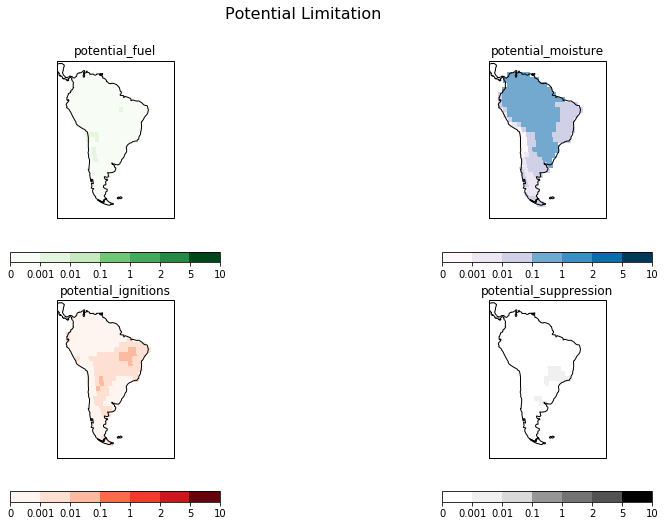

In [18]:
plot_fire_month(mnths = fire_Season)

#### Sensitivty

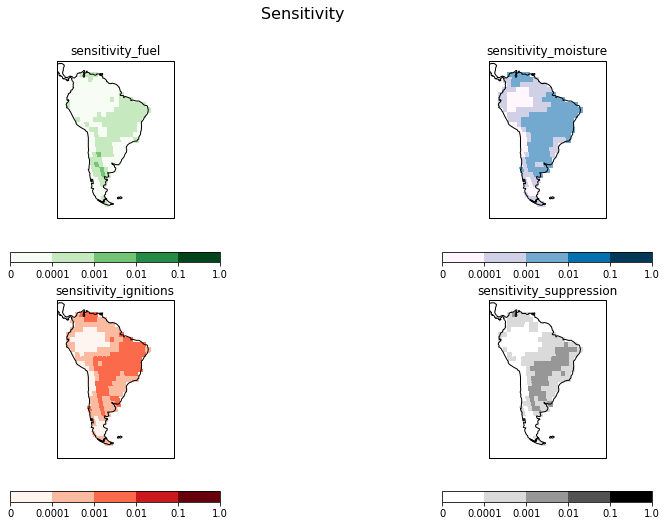

In [19]:
levels = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
def plot_fire_month(**kw):
    plt.figure(figsize = (10, 7.5))
        
    plotModComponet(model.sensitivity_fuel(), 1, levels = levels,
                    cmap = cmap_fuel)
    plotModComponet(model.sensitivity_moisture(), 2, levels = levels,
                    cmap = cmap_moisture)
    plotModComponet(model.sensitivity_ignitions(), 3, levels = levels,
                    cmap = cmap_ignitions)
    plotModComponet(model.sensitivity_suppression(), 4, levels = levels,
                    cmap = "Greys")
    plt.suptitle('Sensitivity', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month()

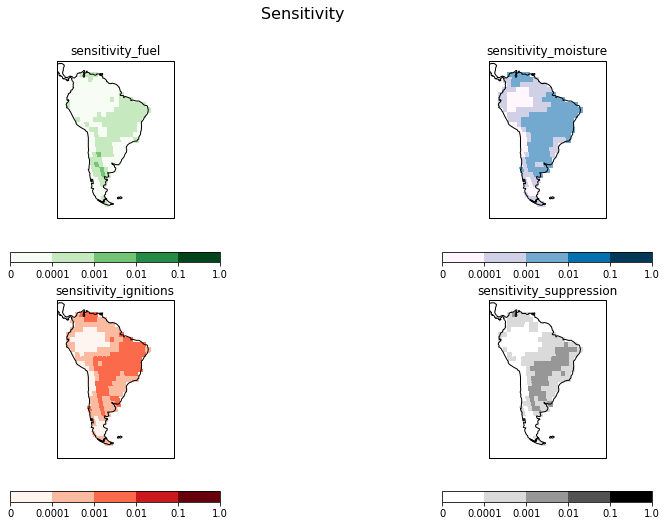

In [20]:
plot_fire_month(mnth = fire_Season)

### Bootstrapping Postieor
So, thats all been looking at just one, albiet very likely parameter combination. The really useful thing about this framework is the uncertainty in the parameters. I'll probably add some visulaisation of that here at some point, but the main thing is to sample the postiror so you can go away and do you own analysis. 

First off some switches. Which things do you want to get a sample for?:

* ```output_controls``` for fuel, moistire, igntions and sepression
* ```output_<<<xxx>>``` output the <<xxx>> type of limitation or sensitivity.

The more you have switched on, the long it takes. But the more cool results you'll have!

In [107]:
output_controls = True
output_standard_limitation = True
output_potential_limitation = True
output_sensitivity = True
output_fullPost = True

Next we have the number of parameter combinations we want to sample (```n_posterior_sample```) - the more the better detail but the longer the time. ```step``` is descibed the sampling gap for the paramater combination + error. The unit is fractional burnt area. The small the step, the more detailed you overall postiror (i.e P(fire| (B | Obs)), but the slower. You might not need P(fire| (B | Obs). In which case, set this to ```None``` and enjoy the extra quick processing time!

```qs``` is the percentiles we'll use to summerise the prbablity density curves at the end. I just set this to 1-99% at 1% intervals... might be overkill (maybe you just need 1, 5, 10, 25, 50, 75, 90, 95, 99 for example). But its so quick compared to everything else, that I'd rather set this detailed so I dont have to rerun.

Finally, we set a directory to stick a load of outputs we're about to generate

In [187]:
regionDir = '../inputs/amazon_region/treeCoverTrendRegions-'
regionIDs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
n_posterior_sample = 1000

qs = np.arange(1, 100, 1)
output_dir = '../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/'

BAs = model.burnt_area_pdf.coord("model_level_number").points
BAs = 1/(1+np.exp(-BAs))

Now lets do some sampling.... I still need to comment through this. Watch this space....

In [188]:
def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
        weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [189]:

n_posterior = params.shape[0]
ngap = int(n_posterior/n_posterior_sample)
if ngap == 0: ngap = 1

try: os.mkdir(output_dir)
except: pass

output_dir = output_dir + title_output +'/'
try: os.mkdir(output_dir)
except: pass

In [190]:
def bootSamples(x, samples = BAs, nsample = 1):
    def bootSample(x):
        if np.sum(x) == 0: return np.repeat(0, n_posterior_sample)
        try:
            out = np.random.choice(samples, nsample, p =x/np.sum(x))
        except:
            browser()        
        return out
    x = np.apply_along_axis(bootSample, 0, x)
    return(x)
def regionA(ID, burnt_area, burnt_area_pdf):
    
    mask = iris.load(regionDir + ID + '.nc')[0]
    
    BA = burnt_area.data[:, mask.data == 1].data
    
    BA = np.mean(BA, axis = 1)  
    
    PDFR = burnt_area_pdf.data[:,:, mask.data == 1].data
    PDFR = PDFR[:,:,PDFR[0, 0, :]>0.0]    
        
    PDFR = bootSamples(PDFR)
    PDFR = np.mean(PDFR[0], axis = 1)
    
    BAa = anomolize(BA)
    PDFRa = anomolize(PDFR)
   
    return BA, BAa, PDFR, PDFRa


def anomolize(x):
    xa = x.copy()
    for mn in range(12):
        xa[mn::12] = x[mn::12] / np.mean(x[mn::12])
    return xa

def regionsAnomoly(*args):    
    return np.array([regionA(ID, *args) for ID in regionIDs]) 
    
reginfo = regionsAnomoly(model.burnt_area, model.burnt_area_pdf)


In [192]:
fire_outi = []

for i in range(0, n_posterior, ngap):
    model = ConFIRE(input_data, params.iloc[i])
    burnt_area = model.burnt_area_mean
    
    reginfo = regionsAnomoly(burnt_area, model.burnt_area_pdf)
    if i == 0:
        uncert = [reginfo[:,0,:]]
        uncert_anom = [reginfo[:,1,:]] 
        error = [reginfo[:,2,:]]
        error_anom = [reginfo[:,3,:]] 
    else:
        uncert = np.insert(uncert, 0, [reginfo[:,0,:]], axis = 0)
        uncert_anom = np.insert(uncert_anom, 0, [reginfo[:,1,:]] , axis = 0)
        error = np.insert(error, 0, [reginfo[:,2,:]], axis = 0)
        error_anom = np.insert(error_anom, 0, [reginfo[:,3,:]] , axis = 0)
        
    cubes = [model.burnt_area_mean, model.burnt_area_mode]
    if output_fullPost:
        if i == 0:
            fullPost = model.burnt_area_pdf
        else:
            fullPost = fullPost + model.burnt_area_pdf   

    if output_controls:
        cubes = cubes + [model.fuel, model.moisture, 
                         model.ignitions, model.suppression]

    if output_standard_limitation:
        cubes = cubes + [model.standard_fuel, model.standard_moisture, 
                         model.standard_ignitions, model.standard_suppression]

    if output_potential_limitation:
        cubes = cubes + [model.potential_fuel(), model.potential_moisture(),                 
                         model.potential_ignitions(), model.potential_suppression()]

    if output_sensitivity:
        cubes = cubes + [model.sensitivity_fuel(), model.sensitivity_moisture(),                  
                         model.sensitivity_ignitions(), model.sensitivity_suppression()]

    cubes = iris.cube.CubeList(cubes) 

    fire_outi = fire_outi + [cubes]
    outFile = output_dir + 'sample_no_' + str(i) +'.nc'
    print(outFile)
    iris.save(cubes, outFile)

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_0.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_6

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_5700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_5800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_5900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_6000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_6100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_6200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sam

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_11400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_11500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_11600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_11700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_11800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_11900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_17100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_17200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_17300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_17400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_17500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_17600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_22800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_22900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_23000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_23100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_23200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_23300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_28500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_28600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_28700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_28800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_28900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_29000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_34200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_34300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_34400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_34500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_34600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_34700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_39900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_40000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_40100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_40200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_40300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_40400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_45600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_45700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_45800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_45900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_46000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_46100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_51300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_51400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_51500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_51600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_51700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_51800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_57000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_57100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_57200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_57300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_57400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_57500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_62700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_62800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_62900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_63000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_63100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_63200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_68400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_68500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_68600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_68700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_68800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_68900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_74100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_74200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_74300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_74400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_74500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_74600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_79800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_79900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_80000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_80100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_80200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_80300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_85500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_85600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_85700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_85800.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_85900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_86000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_91200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_91300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_91400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_91500.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_91600.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_91700.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_96900.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_97000.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_97100.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_97200.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_97300.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/sample_no_97400.nc
../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_

In [193]:
variable = 'burnt_area'
if output_fullPost:
    def cell_weighted_percentile(cell_in):
        
        cell = cell_in.data
        if cell[0] < 0: return(np.ones(len(qs)) * cell[0])
    
        out = weighted_percentile(fullPost.coord("model_level_number").points, qs, cell)
        if out[0] > out[-1]: browser()
        return(out)

    quatilesData = np.apply_along_axis(cell_weighted_percentile, 0, fullPost.data)
    
    percentile_cube = newCubes3D(variable, qs, fullPost[0]) 
    
    percentile_cube.data = np.ma.array(quatilesData, mask = percentile_cube.data.mask.copy())
    percentile_cube.data = 1.0/(1.0 + np.exp(-percentile_cube.data))
    fullPost.long_name = variable + '_frequency_of_occurnace'
    #cubes_summ.standard_name = 'frequency_of_occurnace'
    percentile_cube.long_name = variable + '_at_percentile'
    outFile_summ = output_dir + 'fire_summary_'
    #browser()
    cubes_summ  = iris.cube.CubeList([percentile_cube]) 
    iris.save(cubes_summ, outFile_summ + 'precentile.nc')
    
    cubes_summ  = iris.cube.CubeList([fullPost]) 
    iris.save(cubes_summ, outFile_summ + 'frequancy_of_counts.nc')

fire_out = []
for i in range(len(fire_outi[0])):
    #print(i)
    outi = []
    for out in fire_outi:
        outi = outi + [out[i].data]

    percentile_cube = newCubes3D(variable, qs, out[i]) 
    percentile_cube.data = np.percentile(np.array(outi), qs, 0)
    
    fire_out = fire_out + [percentile_cube]

outFile = output_dir + 'model_summary.nc'

fire_out = iris.cube.CubeList(fire_out) 
print(outFile)
iris.save(fire_out, outFile)

output_dirR = output_dir + 'regions3/'

def mkDir(dir):
    try: os.mkdir(dir)  
    except: pass

mkDir(output_dirR)

        
    #liklihood('A')    

../outputs/sampled_posterior_ConFire_solutions_squishy_full_crop2/constant_post_2018_full_2002_BG2020_rev_logitnorm_Long_PT_EX/model_summary.nc


In [194]:
paramPost = fullPost.copy()
paramPost.data[:] = 0.0
x0 = paramPost.coord('model_level_number').points[0]
dx = paramPost.coord('model_level_number').points[1] - paramPost.coord('model_level_number').points[0]
for i in fire_outi:
    BA_sample = i[1].copy()
    BA_sample.data = npLogit(BA_sample.data)
    BA_sample = (BA_sample - x0)/dx
    BA_sample.data = np.round(BA_sample.data)


    for k in range(paramPost.shape[0]):
        paramPost.data[k][BA_sample.data == k] += 1
    


In [298]:
def anomolize(x):
    xa = x.copy()
    for mn in range(12):
        xa[mn::12] = x[mn::12] / np.mean(x[mn::12])
    
    return xa

def obsAnomolise(ID):
    mask = iris.load(regionDir + ID + '.nc')[0]
    
    dat = input_data["burnt_area"].data[:,mask.data == 1]
    dat = np.mean(dat, axis = 1)
   
    return anomolize(dat)
yay = obsAnomolise('B')
#region_obs_anomolie = np.array([ for ID in regionIDs])

2.9611647099275165

In [268]:
1E-32


1e-32

In [286]:
yay = np.array([0, 2, 3, 4])
yay = np.append(0, yay)
yay


array([0, 0, 2, 3, 4])

In [ ]:
def liklihood(ID = None):
    pnts = 1/(1+np.exp(-fullPost.coord("model_level_number").points))
    
    if ID is None:
        obs = input_data[variable].data
        out = input_data[variable].copy()
        out.data[out.data > 0] = 0
        posterior_pos = out.data   
        Fpost = fullPost.data.copy()
        tot = fullPost.collapsed("model_level_number", iris.analysis.SUM).data
    else:
        mask = iris.load(regionDir + ID + '.nc')[0]
        
        obs = input_data[variable].data[:, mask.data == 1].data.copy()
        obs[obs == 0] = 1E-31
        obs = np.mean(npLogit(obs), axis = 1)
        obs = 1/(1+np.exp(-obs))
        obs = np.append(0,obs)
        obs_anom = obsAnomolise(ID)
        
        obs = np.append(0,obs_anom)
        posterior_pos = np.repeat(0.0, len(obs))
        tot = 10000
        def makeFpost(inPost):
            maskPost = inPost.data[:,:,mask.data == 1]
            ncs = maskPost.shape[2]
            index = np.arange(len(pnts))
            
            def post4Month(mn):
                def sampleCell(c):
                    ps = maskPost[:,mn,c]/ np.sum(maskPost[:,mn,c])
                    return np.random.choice(index, size = 10000, p = ps)

                samples = np.array([sampleCell(c) for c in range(ncs)])
                sample = np.floor(np.mean(samples, axis = 0))
            
                post = np.repeat(0, len(pnts))
                for i in sample: post[int(i)] += 1
                return post
            return np.array([post4Month(mn) for mn in range(maskPost.shape[1])]).T
            
        Fpost = makeFpost(fullPost)
        Ppost = makeFpost(paramPost)
    posterior_p_value = posterior_pos.copy()
    p_value_tester = posterior_pos.copy()
        
    for k in range(len(pnts)):
        pnt = pnts[k]
        dk = k+1 if k == 0 else  k-1
        step = np.abs(pnt - pnts[dk])/2.0
        test1 = obs < (pnt - step)        
        test2 = np.abs(obs - pnt) <= step
        
        posterior_pos[test1] += Fpost[k][test1]
        p_value_tester[test2] = Fpost[k][test2]
        
    for k in range(fullPost.shape[0]):
        test = Fpost[k] > p_value_tester.data
        posterior_p_value[test] += Fpost[k][test]

    posterior_pos /= tot
    posterior_p_value /= tot
    
    if ID is None:
        posterior_pos_out = out.copy()
        posterior_p_value_out = out.copy()
        posterior_pos_out.data = posterior_pos
        posterior_p_value_out.data = posterior_p_value
        posterior_p_value_out.long_name = 'p_value'
        posterior_pos.long_name = 'observed_posterior_position'

        cubes_summ  = iris.cube.CubeList([posterior_p_value_out, posterior_pos_out]) 
        iris.save(cubes_summ, outFile_summ + 'observed_liklihood.nc')
    else:
        outFile_summR = output_dirR  + ID + '-fire_summary_'
        def saveCSV(out, fname):
            np.savetxt(outFile_summR + fname + '.csv', out, delimiter = ",")
            
        saveCSV(posterior_pos, 'observed_posterior_position')
        saveCSV(posterior_p_value, 'p_value')
        
        def saveProb_anom(ipost, fname):
            out = Prob_anom(Fpost, obs_anom)
            saveCSV(out[0], 'Quants_Anom-'+ fname + 'Q')
            saveCSV(out[1], 'Prob_Anom-'+ fname + 'P')
            saveCSV(out[2], 'Obs_Anom-'+ fname + 'O')
            
        saveProb_anom(Fpost,'error')
        saveProb_anom(Ppost,'uncert')
        
        saveCSV(Fpost, 'Full_Posterior')
        saveCSV(obs_anom, 'Obs_anomolieO')
        saveCSV(obs, 'Obs')
        
        #PDFR = bootSample(PDFR)

liklihood('A')

In [ ]:
def Prob_anom(Fpost, obs_anom):
    Panaom = np.repeat(0.0, Fpost.shape[1])
    Oanaom = Panaom.copy()
    Qanaom = np.tile(0.0, [len(qs), Fpost.shape[1]])
    samples = np.arange(len(BAs))
    BAt = npLogit(BAs)
    for m in range(12):
        Fposti = Fpost[:,range(1, Fpost.shape[1], 12)]
    
        boots = bootSamples(Fposti, samples, 1000)
        climP = np.mean(boots, axis = 1)
        climP = np.round(climP)
        Fpost_clim = np.repeat(0.0, len(BAs))    
        for i in climP: Fpost_clim[int(i)] += 1.0/1000
        boot_clim1 = np.random.choice(BAs, 1000, p = Fpost_clim)
        boot_clim2 = np.random.choice(BAt, 1000, p = Fpost_clim)
        for yr in range(Fposti.shape[1]):
            Fpostm = Fposti[:,yr]
            Fpostm = Fpostm/np.sum(Fpostm)

            boot_m1 = np.random.choice(BAs, 1000, p = Fpostm)
            boot_m2 = np.random.choice(BAt, 1000, p = Fpostm)
            A1 = boot_m1/boot_clim1
            A2 = boot_m2/boot_clim2
            
            tin = yr*12 +m
            Panaom[tin] = np.mean(boot_m1 > boot_clim1)
            Qanaom[:, tin] = np.percentile(A2, qs)
            
            Oanaom[tin] = np.mean(A1>obs_anom[tin])
    return Qanaom, Panaom, Oanaom

#for i in range(len(BAs)): Fpost_anom[i] += Fpost_clim[i] * Fposti[i,17]
#plt.plot(Fpost_anom/100)
#npLogit(BAs)
#plt.plot(climP)
#boots
liklihood('A')

In [ ]:
for (idn, ID) in zip(range(len(regionIDs)), regionIDs):    
    liklihood(ID)
    mask = iris.load(regionDir + ID + '.nc')[0]
    fullPostR = fullPost.data[:,:, mask.data == 1].data
    fullPostR = fullPostR[:,:,fullPostR[0, 0, :]>0.0]
    def bootSample(x):
        if np.sum(x) == 0: return np.repeat(0, n_posterior_sample)
        try:
            out = np.random.choice(BAs, n_posterior_sample, p =x/np.sum(x))            
        except:
            browser()
        
        return out
        
    #error = np.apply_along_axis(bootSample, 0, fullPostR)
    
    #def anomolies(x):
    #    for mn in range(12):
    #        x[mn::12] = x[mn::12] / np.mean(x[mn::12])
    #    return x

    #error = np.apply_along_axis(np.mean, 2, error)
    
    #error = 1.0/(1.0+np.exp(-error))
    #error_anomolies = np.apply_along_axis(anomolies, 1, error.copy())  
    #browser()
    #error = np.quantile(error, np.arange(0.01, 1.00, 0.01),0)
    #error_anomolies = np.quantile(error_anomolies, np.arange(0.01, 1.00, 0.01),0)
    
    uncert_anomolies = np.quantile(uncert_anom[:,idn,:], np.arange(0.01, 1.00, 0.01),0)
    uncerti = np.quantile(uncert[:,idn,:], np.arange(0.01, 1.00, 0.01),0)    
    
    error_anomolies = np.quantile(error_anom[:,idn,:], np.arange(0.01, 1.00, 0.01),0)
    errori = np.quantile(error[:,idn,:], np.arange(0.01, 1.00, 0.01),0)  
    
    np.savetxt(output_dirR + ID + '-error.csv', errori, delimiter=",")
    np.savetxt(output_dirR + ID + '-error_anomolie.csv', error_anomolies, delimiter=",")
    np.savetxt(output_dirR + ID + '-uncert.csv', uncerti, delimiter=",")
    np.savetxt(output_dirR + ID + '-uncert_anomolie.csv', uncert_anomolies, delimiter=",")

    print(output_dirR)
    
    

In [ ]:
np.savetxt(output_dirR + 'BAs.csv', BAs)

In [ ]:
plt.show()

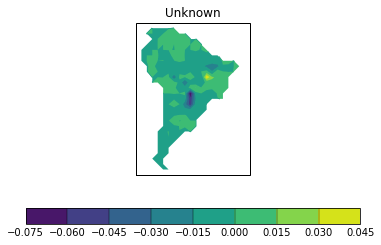

In [244]:
qplt.contourf(input_data[variable][8] - input_data[variable][7])
